# Generating tables and plots for the paper

The code in this notebook generates Tables 4 and 5, Figures 5 and 6 in our paper on [Provenance Graph Kernel](https://arxiv.org/abs/2010.10343). It is run automatically as part of the evaluation pipeline (`make plots`).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
from scripts.experiments.common import method_short_names

## Loading scoring and timing data

In [3]:
def load_scoring(dataset_id) -> pd.DataFrame:
    outputs_folder = Path("outputs") / dataset_id
    output_filepath = outputs_folder / "scoring.pickled"
    
    results = pd.read_pickle(output_filepath)
    
    return results

In [4]:
# Identifiers for the six datasets
dataset_ids = ["MIMIC-PXC7", "CM-Buildings", "CM-Routes", "CM-RouteSets", "PG-T", "PG-D"]
dataset_names = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]

In [5]:
# The following graph kernels are in the "slow" group
slow_GKs = {
    "GK-GSamp",
    "GK-NSPD",
    "GK-NH",
    "GK-SPath",
    "GK-WL-OA-1",
    "GK-WL-OA-2",
    "GK-WL-OA-3",
    "GK-WL-OA-4",
    "GK-WL-OA-5",
}

def name_group(method: str) -> str:
    if method in slow_GKs:
        return "GK-slow"
    elif method.startswith("GK-"):
        # all other graph kernels are in the "fast" group
        return "GK-fast"
    elif method.startswith("PNA-"):
        # Provenance Network Analytics method
        return "PNA"
    elif method.startswith("FG-"):
        # provenance kernels using generic PROV types
        return "PK-G"
    elif method.startswith("FA-"):
        # provenance kernels using generic PROV types and application types
        return "PK-A"
    else:
        return "AppData"

def best_performers(results: pd.DataFrame, scoring="accuracy"):
    # Give them a group name for plotting
    results = results.copy()
    # add a "group_name" column to the table
    results["group_name"] = results.method.map(name_group)

    best_methods = {
        # for each group, find the method that has the best mean scoring (default to accuracy)
        results[results.group_name == group_name].groupby("method")[scoring].mean().idxmax()
        for group_name in ["PK-G", "PK-A", "PNA", "GK-slow", "GK-fast"]
    }

    # return a filtered table with only the best methods identified above
    return results[results.method.isin(best_methods)]

### Loading scoring of the best methods

In [6]:
scorings = pd.DataFrame()

for dataset_id, dataset_name in zip(dataset_ids, dataset_names):
    # load the scoring data for this classification task
    df = load_scoring(dataset_id)
    df["dataset"] = dataset_name
    # only keep the scoring data of the best-performing methods in this task
    scorings = scorings.append(
        best_performers(df),
        ignore_index=True
    )

## Comparing timings of the best methods in each classification task

In [7]:
summary = scorings.groupby(["dataset", "group_name", "method"]).mean()
summary

accuracy        f1    recall  precision  \
dataset group_name method                                                
CM-B    GK-fast    GK-HC-2     0.896928  0.896928  0.896928   0.896928   
        GK-slow    GK-NSPD     0.901972  0.901972  0.901972   0.901972   
        PK-A       FA-2        0.897807  0.897807  0.897807   0.897807   
        PK-G       FG-3        0.899268  0.899268  0.899268   0.899268   
        PNA        PNA-RF      0.894662  0.894662  0.894662   0.894662   
CM-R    GK-fast    GK-WL-4     0.979887  0.979887  0.979887   0.979887   
        GK-slow    GK-WL-OA-5  0.971577  0.971577  0.971577   0.971577   
        PK-A       FA-3        0.970018  0.970018  0.970018   0.970018   
        PK-G       FG-4        0.917264  0.917264  0.917264   0.917264   
        PNA        PNA-RF      0.933604  0.933604  0.933604   0.933604   
CM-RS   GK-fast    GK-WL-3     0.945211  0.945211  0.945211   0.945211   
        GK-slow    GK-WL-OA-5  0.963514  0.963514  0.963514   0.963514   
        PK-A       FA-2        0.966472  0.966472  0.966472   0.966472   
        PK-G       FG-5        0.958134  0.958134  0.958134   0.958134   
        PNA        PNA-DTree   0.940244  0.940244  0.940244   0.940244   
MIMIC   GK-fast    GK-WL-2     0.804666  0.804666  0.804666   0.804666   
        GK-slow    GK-GSamp    0.811755  0.811755  0.811755   0.811755   
        PK-A       FA-2        0.797798  0.797798  0.797798   0.797798   
        PK-G       FG-4        0.771957  0.771957  0.771957   0.771957   
        PNA        PNA-SVM     0.751114  0.751114  0.751114   0.751114   
PG-D    GK-fast    GK-WL-5     0.757500  0.757500  0.757500   0.757500   
        GK-slow    GK-SPath    0.775000  0.775000  0.775000   0.775000   
        PK-A       FA-2        0.782083  0.782083  0.782083   0.782083   
        PK-G       FG-5        0.753250  0.753250  0.753250   0.753250   
        PNA        PNA-SVM     0.712000  0.712000  0.712000   0.712000   
PG-T    GK-fast    GK-OddSth   0.718333  0.718333  0.718333   0.718333   
        GK-slow    GK-WL-OA-5  0.701583  0.701583  0.701583   0.701583   
        PK-A       FA-3        0.853250  0.853250  0.853250   0.853250   
        PK-G       FG-3        0.692333  0.692333  0.692333   0.692333   
        PNA        PNA-DTree   0.693083  0.693083  0.693083   0.693083   

                                     time  
dataset group_name method                  
CM-B    GK-fast    GK-HC-2       0.116795  
        GK-slow    GK-NSPD       2.969497  
        PK-A       FA-2          0.675822  
        PK-G       FG-3          0.619746  
        PNA        PNA-RF       21.819355  
CM-R    GK-fast    GK-WL-4       0.510001  
        GK-slow    GK-WL-OA-5   34.971503  
        PK-A       FA-3          1.766178  
        PK-G       FG-4          1.715778  
        PNA        PNA-RF       71.380516  
CM-RS   GK-fast    GK-WL-3       0.990284  
        GK-slow    GK-WL-OA-5   98.120493  
        PK-A       FA-2          2.877038  
        PK-G       FG-5          3.787513  
        PNA        PNA-DTree   141.582288  
MIMIC   GK-fast    GK-WL-2       1.969433  
        GK-slow    GK-GSamp    450.029107  
        PK-A       FA-2          8.880934  
        PK-G       FG-4         10.529443  
        PNA        PNA-SVM     507.282700  
PG-D    GK-fast    GK-WL-5       0.644547  
        GK-slow    GK-SPath      4.994252  
        PK-A       FA-2          2.934569  
        PK-G       FG-5          4.147640  
        PNA        PNA-SVM     179.027671  
PG-T    GK-fast    GK-OddSth     2.652736  
        GK-slow    GK-WL-OA-5    6.283010  
        PK-A       FA-3          1.175991  
        PK-G       FG-3          1.144574  
        PNA        PNA-DTree    44.998727

### Finding the time cost of the best PK method (between PK-G and PK-A)

In [8]:
best_pk_accuracy = dict()  # best accuracy between PK-G and PK-A for a classification task
best_pk_method = dict()  # achieved by which method
best_pk_time = dict()  # and its corresponding time cost

for row in summary.itertuples():
    dataset, group_name, method = row.Index

    if group_name in {"PK-G", "PK-A"}:
        to_be_updated = True
        try:
            if best_pk_accuracy[dataset] > row.accuracy:
                to_be_updated = False
        except KeyError:
            pass  # first time seeing this dataset, to reco

        if to_be_updated:
            best_pk_accuracy[dataset] = row.accuracy
            best_pk_method[dataset] = method
            best_pk_time[dataset] = row.time

### Calculating the relative time for all methods in each classification task

In [9]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    relative_time = row.time / best_pk_time[dataset]
    data.append((dataset, group_name, method, row.accuracy, relative_time))

rel_time_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Accuracy", "Relative Time"])

### Table 4
Within each dataset, we report the time cost of the best-performing method (shown in parentheses) from each comparison group relative to the time taken by the best-performing PK method (whose time cost shown as 1.0).

In [10]:
rel_time_df["time_method"] = rel_time_df.apply(
    lambda row: "%.1f (%s)" % (row[4], method_short_names[row[2]]),
    axis=1
)

In [11]:
table4 = rel_time_df.pivot(index="Dataset", columns="Group", values="time_method").reindex(dataset_names)[
    ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
]
table4

Group,PK-G,PK-A,GK-fast,GK-slow,PNA
Dataset,,,,,
MIMIC,1.2 (G4),1.0 (A2),0.2 (WL2),50.7 (GS),57.1 (SVM)
CM-B,1.0 (G3),1.1 (A2),0.2 (HC2),4.8 (NSPD),35.2 (RF)
CM-R,1.0 (G4),1.0 (A3),0.3 (WL4),19.8 (WLO5),40.4 (RF)
CM-RS,1.3 (G5),1.0 (A2),0.3 (WL3),34.1 (WLO5),49.2 (DT)
PG-T,1.0 (G3),1.0 (A3),2.3 (ODD),5.3 (WLO5),38.3 (DT)
PG-D,1.4 (G5),1.0 (A2),0.2 (WL5),1.7 (SP),61.0 (SVM)


In [12]:
# Save table 4 for later
table4.to_csv("plots/table4.csv")
table4.to_html("plots/table4.html")

## Comparing the accuracy of the best PK method vs the best in the other comparison groups

In [13]:
def ranksums(df: pd.DataFrame, methods, scoring="accuracy", pvalue_significant=0.05):
    # returns None if the difference between the two methods is not statistically significant
    # according to the ranksums test; otherwise, returns the mean difference value.

    assert len(methods) == 2
    assert scoring in df.columns

    print("Wilcoxon rank-sum test:", scoring)
    print(f"> Comparing {methods[0]} vs {methods[1]}")

    p1 = df[df.method == methods[0]]
    p1.reset_index(inplace=True)
    p1_mean = p1[scoring].mean()

    p2 = df[df.method == methods[1]]
    p2.reset_index(inplace=True)
    p2_mean = p2[scoring].mean()

    mean_diff = p1_mean - p2_mean
    _, pvalue = stats.ranksums(p1[scoring], p2[scoring])
    if pvalue > pvalue_significant:
        print(f"> Insignificant (pvalue = {pvalue * 100:.1f}%)")
        return None
    else:
        print(f"> *Significant* (pvalue = {pvalue * 100:.1f}%)")
        print(f"> Mean difference: {mean_diff * 100:+.1f}%")
        return mean_diff

### Table 5

Summary of the accuracy differences between the best-performing PK-based method and the best-performing method in the GK-slow, GK-fast, and PNA groups. An “=” sign means the accuracy difference is not statistically significant according to the Wilcoxson Rank Sum test (also known as Mann Whitney U Test); while a positive/negative value shows how much the PK-based method outperforms/under-performs the corresponding GK/PNA method, respectively, when the difference is statistically significant.

In [14]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    
    if group_name in {"PK-G", "PK-A"}:
        continue  # not comparing PK group with itself
    
    mean_diff = ranksums(scorings[scorings.dataset == dataset], [best_pk_method[dataset], method])
    cell_value = f"{mean_diff * 100:.1f}%" if mean_diff is not None else "="
    data.append((dataset, group_name, method, cell_value))
    
comparison_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Diff"])

Wilcoxon rank-sum test: accuracy
> Comparing FG-3 vs GK-HC-2
> Insignificant (pvalue = 47.0%)
Wilcoxon rank-sum test: accuracy
> Comparing FG-3 vs GK-NSPD
> Insignificant (pvalue = 41.0%)
Wilcoxon rank-sum test: accuracy
> Comparing FG-3 vs PNA-RF
> Insignificant (pvalue = 19.3%)
Wilcoxon rank-sum test: accuracy
> Comparing FA-3 vs GK-WL-4
> *Significant* (pvalue = 0.0%)
> Mean difference: -1.0%
Wilcoxon rank-sum test: accuracy
> Comparing FA-3 vs GK-WL-OA-5
> Insignificant (pvalue = 30.1%)
Wilcoxon rank-sum test: accuracy
> Comparing FA-3 vs PNA-RF
> *Significant* (pvalue = 0.0%)
> Mean difference: +3.6%
Wilcoxon rank-sum test: accuracy
> Comparing FA-2 vs GK-WL-3
> *Significant* (pvalue = 0.0%)
> Mean difference: +2.1%
Wilcoxon rank-sum test: accuracy
> Comparing FA-2 vs GK-WL-OA-5
> *Significant* (pvalue = 4.5%)
> Mean difference: +0.3%
Wilcoxon rank-sum test: accuracy
> Comparing FA-2 vs PNA-DTree
> *Significant* (pvalue = 0.0%)
> Mean difference: +2.6%
Wilcoxon rank-sum test: accu

In [15]:
table5 = comparison_df.pivot(index="Group", columns="Dataset", values="Diff").reindex(["GK-slow", "GK-fast", "PNA"])[dataset_names]
table5

Dataset,MIMIC,CM-B,CM-R,CM-RS,PG-T,PG-D
Group,,,,,,
GK-slow,-1.4%,=,=,0.3%,15.2%,=
GK-fast,-0.7%,=,-1.0%,2.1%,13.5%,2.5%
PNA,4.7%,=,3.6%,2.6%,16.0%,7.0%


In [16]:
# Save Table 5 for later
table5.to_csv("plots/table5.csv")
table5.to_html("plots/table5.html")

## Generating plots

In [17]:
# store the current colour palette
current_palette = sns.color_palette()

### Figure 5: The relative time costs of the best-performing methods reported in Table 4 plotted on the log scale

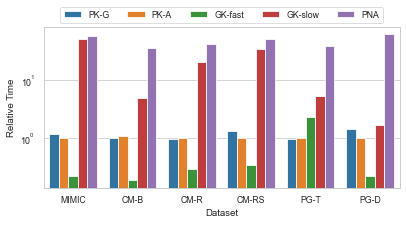

In [18]:
dataset_order = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]
selected_groups = ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
plot = sns.barplot(x="Dataset", y="Relative Time", hue="Group", order=dataset_order, hue_order=selected_groups, data=rel_time_df)
plot.set_yscale("log")
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plot.figure.set_size_inches(5.75, 3.25)
plt.tight_layout()

In [19]:
# saving the above plot
plot.figure.savefig("plots/best-performers-relative-timing.pdf")

### Figure 6: The mean classification accuracy of the best-performing provenance kernels, generic graph kernels, and PNA methods across the six classification tasks. The error bars show the 95-percent confidence intervals

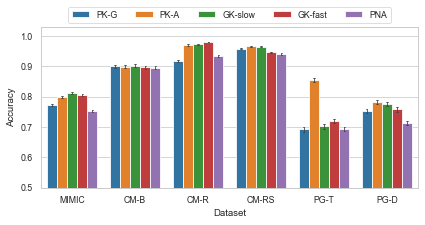

In [20]:
plt.figure()
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]
df = scorings[scorings.group_name.isin(set(selected_groups))]
plot = sns.barplot(x="dataset", y="accuracy", hue="group_name",
                   hue_order=selected_groups, data=df, palette=current_palette,
                   errwidth=0.8, capsize=0.02)
plot.set(xlabel="Dataset", ylabel="Accuracy")
plot.figure.set_size_inches(6, 3.25)
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plt.ylim(0.5)
plt.tight_layout()

In [21]:
plot.figure.savefig("plots/accuracy-best-performers.pdf")